In [79]:
import pandas as pd
import numpy as np
import xarray as xr

import scipy.stats as stats
import matplotlib.pyplot as plt

In [49]:
# testing file
file = xr.open_dataset('/Users/victoriaford/Downloads/ASOSAWOS_72053900165.nc')
df = file.to_dataframe()

/Users/victoriaford/anaconda3/envs/histobs/lib/python3.11/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/victoriaford/anaconda3/envs/histobs/lib/python3.11/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


In [50]:
df = df.reset_index() 
df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
df['year'] = pd.to_datetime(df['time']).dt.year # sets year to new variable

In [51]:
df

,station,time,ps,tas,tdps,sfcWind,sfcWind_dir,elevation,qaqc_process,ps_qc,...,pr_qc,pr_duration,pr_depth_qc,sfcWind_qc,sfcWind_method,sfcWind_dir_qc,lat,lon,month,year
0,ASOSAWOS_72053900165,2009-10-01 20:00:00,NaN,282.15,256.15,0.0,NaN,2335.0,V020,9,...,,NaT,NaN,1,C,9,37.283,-107.05,10,2009
1,ASOSAWOS_72053900165,2009-10-01 20:15:00,NaN,283.15,257.15,3.6,130.0,2335.0,V020,9,...,,NaT,NaN,1,N,1,37.283,-107.05,10,2009
2,ASOSAWOS_72053900165,2009-10-02 16:15:00,NaN,278.15,261.15,0.0,NaN,2335.0,V020,9,...,,NaT,NaN,1,C,9,37.283,-107.05,10,2009
3,ASOSAWOS_72053900165,2009-10-02 16:35:00,NaN,279.15,260.15,1.5,220.0,2335.0,V020,9,...,,NaT,NaN,1,N,1,37.283,-107.05,10,2009
4,ASOSAWOS_72053900165,2009-10-02 17:00:00,NaN,280.15,258.15,0.0,NaN,2335.0,V020,9,...,,NaT,NaN,1,C,9,37.283,-107.05,10,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333960,ASOSAWOS_72053900165,2022-08-31 22:35:00,77460.0,295.65,279.25,4.6,150.0,2335.0,V020,5,...,,NaT,NaN,5,N,5,37.283,-107.05,8,2022
333961,ASOSAWOS_72053900165,2022-08-31 22:55:00,NaN,294.35,279.55,4.6,160.0,2335.0,V020,9,...,,NaT,NaN,1,N,1,37.283,-107.05,8,2022
333962,ASOSAWOS_72053900165,2022-08-31 23:15:00,NaN,294.15,281.05,4.6,190.0,2335.0,V020,9,...,,NaT,NaN,1,N,1,37.283,-107.05,8,2022
333963,ASOSAWOS_72053900165,2022-08-31 23:35:00,NaN,294.35,279.95,4.1,180.0,2335.0,V020,9,...,,NaT,NaN,1,N,1,37.283,-107.05,8,2022


In [57]:
def _plot_format_helper(var):
    """
    Helper function for plots 
    """
    
    if var == 'tas':
        ylab = 'Air Temperature at 2m'
        unit = 'K'
#         ylim = (240, 320)
        
    elif var == 'tdps' or var == 'tdps_derived':
        ylab = 'Dewpoint Temperature'
        unit = 'K'
#         ylim = (230, 300)
        
    elif var == 'sfcWind':
        ylab = 'Surface Wind Speed'
        unit = 'm s-1'
#         ylim = (0, 30)
        
    elif var == 'sfcWind_dir':
        ylab = 'Surface Wind Direction'
        unit = 'degrees'
#         ylim = (0, 360)
        
    elif var == 'rsds':
        ylab = 'Surface Radiation'
        unit = 'W m-2'
#         ylim = (0, 1500)
        
    elif var == 'pr':
        ylab = 'Precipitation'
        unit = 'mm'
#         ylim = (0, 2000)
        
    return (ylab, unit)
    

In [58]:
def _plot_flagged_months(df, var):
    """
    Helper function to plot flagged months in the monthly distributional checks functions
    Currently set-up for monthly gap check.
    Produces a timeseries figure
    """
    
    labels = _plot_format_helper(var=var)
    
    # testing
    flagged_plot = df.plot.scatter(x='time',
                                   y=var,
                                   ylabel=labels[0] + ' ({})'.format(labels[1]),
                                   figsize=(9,3),
                                   s=1,
#                                    ylim=labels[2],
                                   color='k',
                                   label='Testing');
    
#     ax = df_good.plot.scatter(x='time', y=var, figsize=(9,2), s=1, color='k', label='Pass') 
#     df_bad.plot.scatter(x='time', y=var, figsize=(9,2), s=1, color='r', label='Flagged', ax=ax) 

    
    return flagged_plot

<Axes: xlabel='time', ylabel='Air Temperature at 2m (K)'>

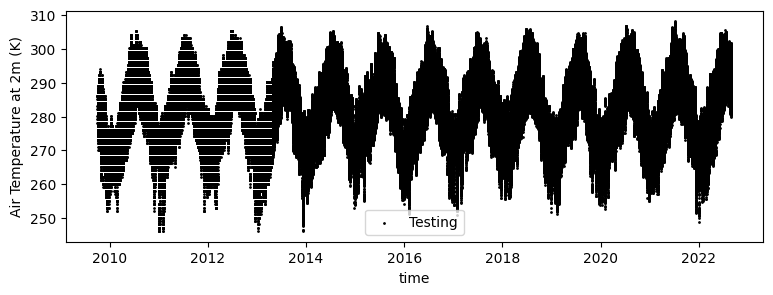

In [66]:
_plot_flagged_months(df, var='tas')

---
part 2 test


In [71]:
## part2 

# compare all observations in a single month, all years
# histogram created from all obs and gaussian distribution is fitted
# threshold values are determined using positions where fitted frequency falls below y=0.1
# and rounding outwards to the next integer plus one
# going outwards from center, distribution is scanned for gaps which occur outside threshold value
# obs beyond gap are flagged


## gaussian distribution may not be a perfect fit for bulk of obs, with thresholds too high
## allow for non-zero skew and kurtosis by using gauss-hermite series
## updated thresholds occur closer to bulk of distribution curve

#--------------------------------------------------------------------------------------
# intention is to have a function like: 

# def qaqc_dist_gaps_check(df, plot=False):
#     if plot=True:
#         plot_gap_check(df, var) # etc. 

In [110]:
def plot_gap_check(df, var):
    
    # plot histogram with count values against the standardized IQR
    num_bins = int(df[var].max()) + 1 - int(df[var].min())
    N = 10000 # what is this number - it matters!
    
    # standardize against IQR range
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1
    df_month_iqr = (df[var].values - df[var].median()) / iqr
    
    x = df_month_iqr
    plt.hist(x, bins=num_bins, alpha=0.3);
    xmin, xmax = plt.xlim()
    
    kur = stats.kurtosis(x, fisher=True)
    sk = stats.skew(x)

    # plot pdf
#     if var == 'tas' or var == 'tdps' or var =='tdps_derived':
# #         plt.xlim([-5,5])
#         y = np.linspace(-5, 5, num_bins)
#     else:
    y = np.linspace(xmin, xmax, num_bins)
    bin_width = (x.max() - x.min()) / num_bins
    plt.plot(y, stats.norm.pdf(y) * N * bin_width, color='k', lw=1)

    # add vertical lines to indicate thresholds -- clearly not correct
    pdf_idx = list(filter(lambda i: i > 0.1, stats.norm.pdf(y)))
    plt.axvline(x=y[stats.norm.pdf(y).tolist().index(pdf_idx[0])], color='r') # left tail
    plt.axvline(y[stats.norm.pdf(y).tolist().index(pdf_idx[-1])], color='r') # right tail
    
    plt.gca().set_yscale('log')

    # flag (visually) obs that are beyond threshold
    # bar_value_to_label = -2.25
    # patch_index = np.digitize([bar_value_to_label], x)[0]
    # hh.patches[patch_index].set_color('r')
    # hh.patches[patch_index].set_alpha(1)

    # title and useful annotations
    plt.title('QA/QC Distributional gap for {0}: {1}'.format(df['station'].unique()[0], var), fontsize=9);
    plt.annotate('Month: {}'.format(m), xy=(0.05, 0.95), xycoords='axes fraction', fontsize=8);
    plt.annotate('Mean: {}'.format(round(np.nanmean(df_month_iqr),3)), xy=(0.05, 0.9), xycoords='axes fraction', fontsize=8);
    plt.annotate('Std.Dev: {}'.format(round(np.nanstd(df_month_iqr),3)), xy=(0.05, 0.85), xycoords='axes fraction', fontsize=8);
    plt.annotate('Skew: {}'.format(round(sk,3)), xy=(0.05,0.8), xycoords='axes fraction', fontsize=8)
    plt.annotate('Kurtosis: {}'.format(round(kur,3)), xy=(0.05, 0.75), xycoords='axes fraction', fontsize=8)
    plt.ylabel('Frequency (obs)')
    plt.xlabel('{} offset (IQR)'.format(var));
    
    # put AWS save figure stuffs here
    
    return

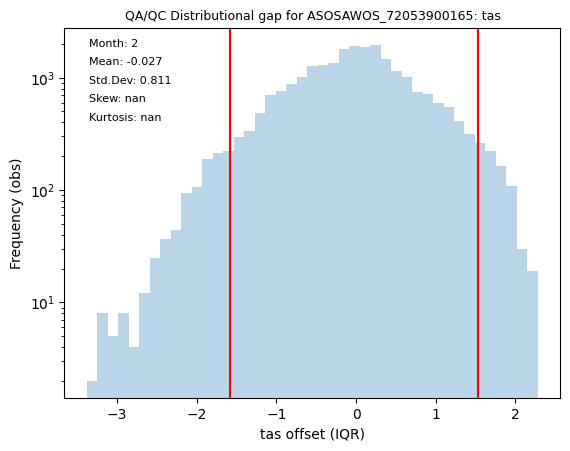

In [111]:
m = 2
df_month = df.loc[df['month'] == m]


plot_gap_check(df_month, var='tas')

In [103]:
def qaqc_dist_gaps_part2(df, plot=True):
    """
    Part 2 / monthly check
        - compare all obs in a single month, all years
        - histogram created from all obs and gaussian distribution fitted
        - threshold values determined using positions where fitted freq falls below y=0.1
        - rounds outwards to next integer plus one
        - going outwards from center, distribution is scanned for gaps which occur outside threshold
        - obs beyond gap are flagged
    Goal: identifies individual suspect observations and flags the entire month  
    """
    
    # run through every var, excluding qaqc/duration/method vars
    vars_to_remove = ['index','station','qc', 'duration', 'method', 'lat', 'lon', 'elevation', 'time', 'month', 'year'] # list of var substrings to exclude if present in var
    vars_to_check = [var for var in df.columns if not any(True for item in vars_to_remove if item in var)] # remove all non-primary variables
    
    # run through each month
    for m in range(1):
        df_month = df.loc[df['month'] == m+1]

        plot_gap_check(df_month, var='tas')
        
        
    
#     return df
    

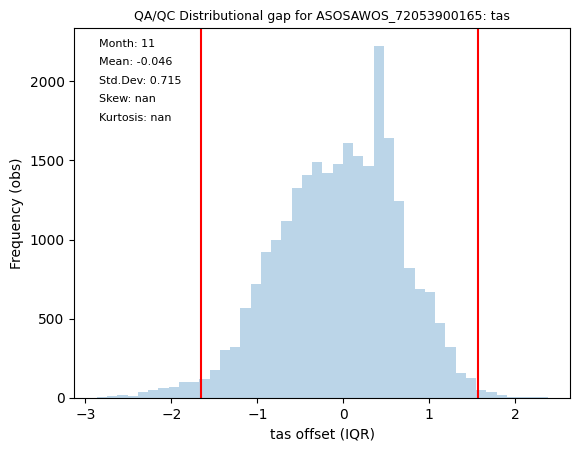

In [104]:
qaqc_dist_gaps_part2(df)

In [180]:
df_month

,station,time,ps,tas,tdps,sfcWind,sfcWind_dir,elevation,qaqc_process,ps_qc,...,pr_qc,pr_duration,pr_depth_qc,sfcWind_qc,sfcWind_method,sfcWind_dir_qc,lat,lon,month,year
19048,ASOSAWOS_72053900165,2010-07-01 00:00:00,NaN,299.15,270.15,4.1,220.0,2335.0,V020,9,...,,NaT,NaN,1,N,1,37.283,-107.05,7,2010
19049,ASOSAWOS_72053900165,2010-07-01 00:15:00,NaN,299.15,269.15,6.2,210.0,2335.0,V020,9,...,,NaT,NaN,1,N,1,37.283,-107.05,7,2010
19050,ASOSAWOS_72053900165,2010-07-01 00:35:00,NaN,299.15,268.15,3.6,200.0,2335.0,V020,9,...,,NaT,NaN,1,N,1,37.283,-107.05,7,2010
19051,ASOSAWOS_72053900165,2010-07-01 01:00:00,NaN,299.15,268.15,5.7,230.0,2335.0,V020,9,...,,NaT,NaN,1,N,1,37.283,-107.05,7,2010
19052,ASOSAWOS_72053900165,2010-07-01 01:15:00,NaN,298.15,270.15,3.6,220.0,2335.0,V020,9,...,,NaT,NaN,1,N,1,37.283,-107.05,7,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331703,ASOSAWOS_72053900165,2022-07-31 22:35:00,77600.0,292.75,286.45,3.6,310.0,2335.0,V020,5,...,,NaT,NaN,5,N,5,37.283,-107.05,7,2022
331704,ASOSAWOS_72053900165,2022-07-31 22:55:00,NaN,292.85,286.45,2.1,320.0,2335.0,V020,9,...,,NaT,NaN,1,N,1,37.283,-107.05,7,2022
331705,ASOSAWOS_72053900165,2022-07-31 23:15:00,NaN,293.25,287.15,1.5,100.0,2335.0,V020,9,...,,NaT,NaN,1,N,1,37.283,-107.05,7,2022
331706,ASOSAWOS_72053900165,2022-07-31 23:35:00,NaN,293.75,287.25,2.1,80.0,2335.0,V020,9,...,,NaT,NaN,1,N,1,37.283,-107.05,7,2022


In [177]:
m = 7
df_month = df.loc[df['month'] == m]
# df_month

In [178]:
# remove nan obs
var = 'tas'
df_month_var = df_month[df_month[var].notnull()][var]

(mu, sigma) = norm.fit(df_month_var)

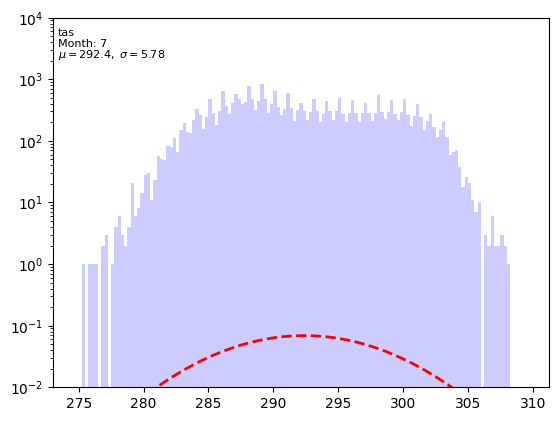

In [191]:
bins = create_bins(df_month['tas'])
n, bins, patches = plt.hist(df_month_var, bins, density=False, log=True, facecolor='blue', alpha=0.2)
y = norm.pdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

plt.annotate(var, xy=(0.01, 0.95), xycoords='axes fraction', fontsize=8)
plt.annotate('Month: {}'.format(m), xy=(0.01, 0.92), xycoords='axes fraction', fontsize=8)
plt.annotate(r'$\mu=%.1f,\ \sigma=%.2f$' %(mu, sigma), xy=(0.01, 0.89), xycoords='axes fraction', fontsize=8);

plt.ylim(10**-2, 10**4);

In [181]:
def create_bins(data, bin_size=0.25):
    '''Create bins from data covering entire data range'''

    # set up bins
    b_min = np.floor(np.min(data))
    b_max = np.ceil(np.max(data))
    bins = np.arange(b_min - bin_size, b_max + (3. * bin_size), bin_size)

    return bins

In [184]:
create_bins(df_month['tas'])

array([274.75, 275.  , 275.25, 275.5 , 275.75, 276.  , 276.25, 276.5 ,
       276.75, 277.  , 277.25, 277.5 , 277.75, 278.  , 278.25, 278.5 ,
       278.75, 279.  , 279.25, 279.5 , 279.75, 280.  , 280.25, 280.5 ,
       280.75, 281.  , 281.25, 281.5 , 281.75, 282.  , 282.25, 282.5 ,
       282.75, 283.  , 283.25, 283.5 , 283.75, 284.  , 284.25, 284.5 ,
       284.75, 285.  , 285.25, 285.5 , 285.75, 286.  , 286.25, 286.5 ,
       286.75, 287.  , 287.25, 287.5 , 287.75, 288.  , 288.25, 288.5 ,
       288.75, 289.  , 289.25, 289.5 , 289.75, 290.  , 290.25, 290.5 ,
       290.75, 291.  , 291.25, 291.5 , 291.75, 292.  , 292.25, 292.5 ,
       292.75, 293.  , 293.25, 293.5 , 293.75, 294.  , 294.25, 294.5 ,
       294.75, 295.  , 295.25, 295.5 , 295.75, 296.  , 296.25, 296.5 ,
       296.75, 297.  , 297.25, 297.5 , 297.75, 298.  , 298.25, 298.5 ,
       298.75, 299.  , 299.25, 299.5 , 299.75, 300.  , 300.25, 300.5 ,
       300.75, 301.  , 301.25, 301.5 , 301.75, 302.  , 302.25, 302.5 ,
      

In [185]:
def iqr(data, percentile=0.25):
    '''Calculate IQR of data'''

    # sort data
    sorted_data = sorted(data)

    n_data = len(sorted_data)
    quartile = int(round(percentile * n_data))

    return sorted_data[n_data - quartile] - sorted_data[quartile] # iqr

In [192]:
def get_monthly_median(data):
    '''Returns monthly median of data'''
    
    return np.ma.median(data)

In [193]:
# month 7, tas
df_month_var

19048     299.15
19049     299.15
19050     299.15
19051     299.15
19052     298.15
           ...  
331703    292.75
331704    292.85
331705    293.25
331706    293.75
331707    293.65
Name: tas, Length: 27971, dtype: float64

In [194]:
get_monthly_median(df_month_var)

291.65

In [202]:
month_med = np.empty(12) # create array of length of months
month_med.fill(np.nan) # fill with nans, not zeros

for m in range(12):
    var = 'tas'
    df_month = df.loc[df['month'] == m+1]
    df_month_var = df_month[df_month[var].notnull()][var]
    
    month_med[m] = get_monthly_median(df_month_var)

In [203]:
month_med

array([269.65, 271.15, 274.75, 279.15, 283.55, 290.65, 291.65, 290.25,
       287.15, 280.15, 274.15, 270.15])

In [214]:
# standardized months

standardized_months = np.empty(12)
standardized_months.fill(np.nan)

for m in range(12):
        
        # calculate climatological median, and IQR
        clim = np.median(month_med[m]) # this needs to be the 
        spread = iqr(df_month_var)
        
        standardized_months[m] = (month_med[m] - clim) / spread

In [215]:
standardized_months

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [216]:
iqr(df_month_var)

7.100000000000023